In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import streamlit as st
import shap
import pickle
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from tpot import TPOTClassifier

In [39]:
df = pd.read_csv('Medical_Dataset.csv').drop('Patient_ID', axis=1)

# Problem List
- Imbalanced: rs9282541, rs4988235, rs9374842

# Data Overview

In [40]:
df.head(10)

,Age,Gender,Race,BMI,Smoker,Blood_Pressure,Diabetes,Heart_Disease
0,69,Female,Asian,20.906457,True,129.150330,False,False
1,32,Male,Black,29.068229,False,137.205259,False,False
2,89,Female,White,23.699933,False,101.642951,True,False
3,78,Male,White,22.849927,True,107.089761,False,False
4,38,Male,White,25.849504,False,105.052435,False,True
5,41,Female,Black,28.431777,False,109.372723,False,True
6,20,Female,Hispanic,21.094451,False,116.556738,False,False
7,39,Male,White,34.925745,False,102.781978,False,False
8,70,Female,White,31.385799,False,95.283245,False,False
9,19,Female,Black,26.173185,False,123.487508,True,False


In [41]:
df.describe()

,Age,BMI,Blood_Pressure
count,1000.000000,1000.000000,1000.000000
mean,52.881000,28.159423,119.956125
std,20.958915,4.984407,19.648002
min,18.000000,11.065931,59.081423
25%,34.750000,24.802625,107.053771
50%,52.500000,28.099120,119.433095
75%,71.000000,31.674884,132.728178
max,89.000000,40.812638,201.051002


# Data Preprocessing

In [42]:
mapping = {'Female': 0, 'Male': 1}
df['Gender'] = df['Gender'].map(mapping)

mapping = {'False': 0, 'True': 1}
df['Smoker'] = df['Smoker'].map(mapping)

mapping = {'False': 0, 'True': 1}
df['Diabetes'] = df['Diabetes'].map(mapping)

mapping = {'False': 0, 'True': 1}
df['Heart_Disease'] = df['Heart_Disease'].map(mapping)


# Data Visualisation

In [43]:
df.dtypes

Age                 int64
Gender              int64
Race               object
BMI               float64
Smoker            float64
Blood_Pressure    float64
Diabetes          float64
Heart_Disease     float64
dtype: object

In [44]:
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

ValueError: could not convert string to float: 'Asian'

# Train-Test Split, TPOT

In [ ]:

# Assume the target variable is named 'target'. Change it to your target column name
X = df.drop(columns=['CardiovascularDisease'])
y = df['CardiovascularDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Export the test set to a CSV file
test_set = pd.concat([X_test, y_test], axis=1)
test_set.to_csv('test_set.csv', index=False)

# Remove the test set from the dataframe
data = pd.concat([X_train, y_train], axis=1)

# Step 5: Use TPOT to find the best model
# Initialize TPOTClassifier
tpot = TPOTClassifier(verbosity=2, generations=5, population_size=50, random_state=42)

# Fit TPOT on the training data
tpot.fit(X_train, y_train)

# Export the best model pipeline code
tpot.export('tpot_best_model.py')

# Evaluate the best model on the test set
score = tpot.score(X_test, y_test)
print(f'Test Accuracy: {score:.4f}')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9958333333333332

Generation 2 - Current best internal CV score: 0.9958333333333332

Generation 3 - Current best internal CV score: 0.9958333333333332

Generation 4 - Current best internal CV score: 0.9958333333333332

Generation 5 - Current best internal CV score: 0.9958333333333333

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=True, criterion=entropy, max_features=0.9500000000000001, min_samples_leaf=15, min_samples_split=2, n_estimators=100)
Test Accuracy: 1.0000


In [ ]:
tpot_data = data.copy()
features = tpot_data.drop('CardiovascularDisease', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['CardiovascularDisease'], random_state=42)

# Average CV score on the training set was: 0.9958333333333333
exported_pipeline = RandomForestClassifier(bootstrap=True, criterion="entropy", max_features=0.9500000000000001, min_samples_leaf=15, min_samples_split=2, n_estimators=100)
# Fix random state in exported estimator
if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', 42)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


In [ ]:
# computing the predicted y for the whole df 
y_pred = exported_pipeline.predict(X)
y_pred_test = exported_pipeline.predict(X_test)
#adding predicted y to the whole df
df_with_predictions = df.copy()
df_with_predictions['predictions'] = y_pred

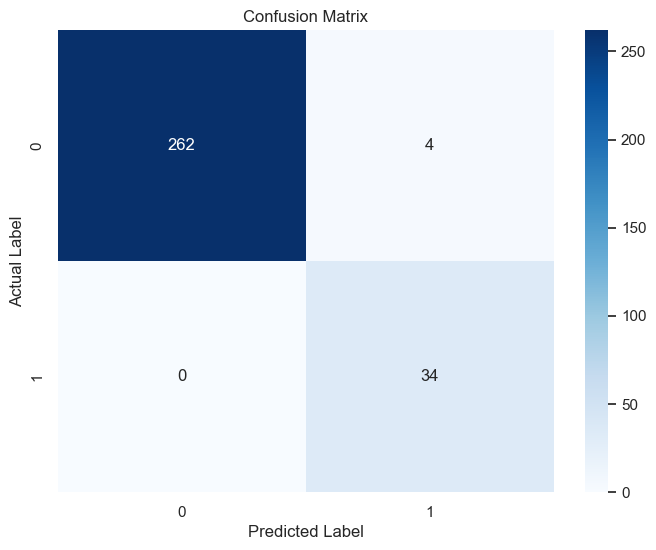

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['Absent', 'Present']))

              precision    recall  f1-score   support

      Absent       1.00      0.98      0.99        54
     Present       0.86      1.00      0.92         6

    accuracy                           0.98        60
   macro avg       0.93      0.99      0.96        60
weighted avg       0.99      0.98      0.98        60



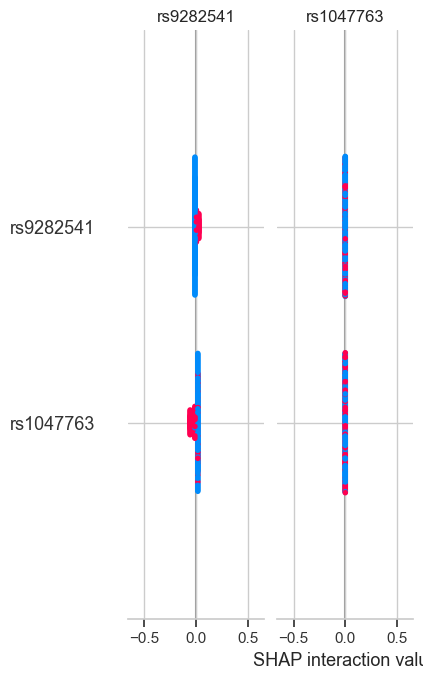

In [ ]:
# Create a SHAP explainer
explainer = shap.TreeExplainer(exported_pipeline, X_train)

# Calculate SHAP values
shap_values = explainer.shap_values(X)

# Summary plot for all features
shap.summary_plot(shap_values, X, plot_type="bar")
plt.show()

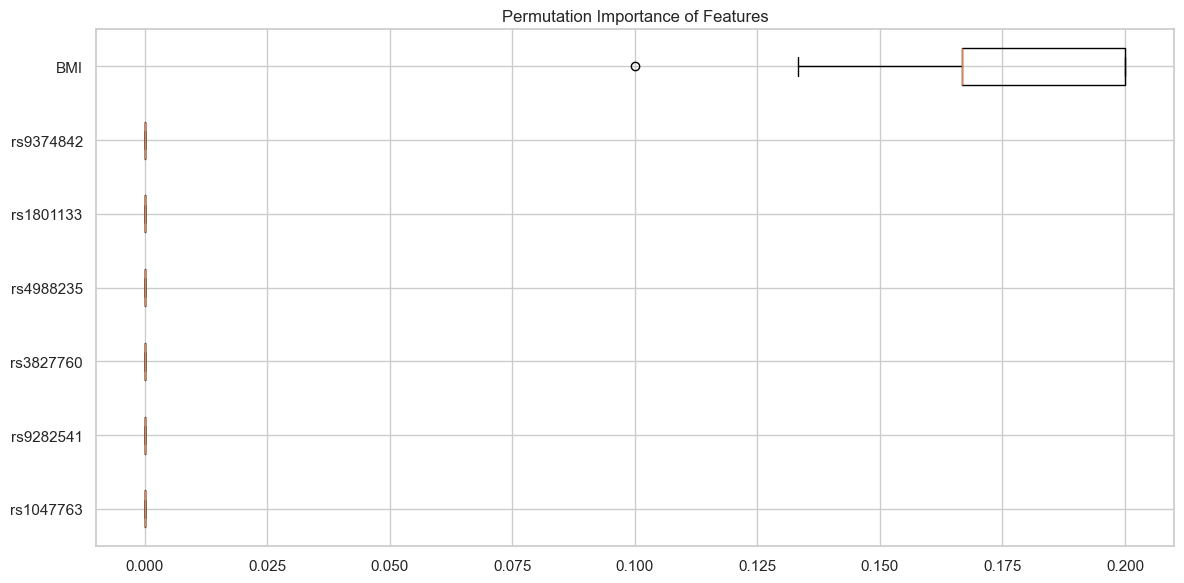

In [ ]:
result = permutation_importance(exported_pipeline, X_test, y_test, n_repeats=10, random_state=42)
sorted = result.importances_mean.argsort()

plt.figure(figsize=(12, 6))
plt.boxplot(result.importances[sorted].T, vert=False, labels=X_test.columns[sorted])
plt.title("Permutation Importance of Features")
plt.tight_layout()
plt.show()



# Dropping BMI

In [ ]:
X_train = X_train.drop(columns=['BMI'])
X_test = X_test.drop(columns=['BMI'])

In [ ]:
data= data.drop(columns=['BMI'])

In [ ]:
tpot_noBMI = TPOTClassifier(verbosity=2, generations=5, population_size=50, random_state=42)

# Fit TPOT on the training data
tpot_noBMI.fit(X_train, y_train)

# Export the best model pipeline code
tpot_noBMI.export('tpot_best_model.py')

# Evaluate the best model on the test set
score_noBMI = tpot_noBMI.score(X_test, y_test)
print(f'Test Accuracy: {score_noBMI:.4f}')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8958333333333333

Generation 2 - Current best internal CV score: 0.8958333333333333

Generation 3 - Current best internal CV score: 0.8958333333333333

Generation 4 - Current best internal CV score: 0.8958333333333333

Generation 5 - Current best internal CV score: 0.8958333333333333

Best pipeline: XGBClassifier(input_matrix, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, n_jobs=1, subsample=1.0, verbosity=0)
Test Accuracy: 0.9000


In [ ]:

tpot_data_noBMI = data.copy()
features = tpot_data_noBMI.drop('CardiovascularDisease', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data_noBMI['CardiovascularDisease'], random_state=42)

# Average CV score on the training set was: 0.8958333333333333
exported_pipeline = XGBClassifier(learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, n_jobs=1, subsample=1.0, verbosity=0)
# Fix random state in exported estimator
if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', 42)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


In [ ]:
X = X.drop(columns=['BMI'])

In [ ]:
# computing the predicted y for the whole df 
y_pred = exported_pipeline.predict(X)
y_pred_test = exported_pipeline.predict(X_test)
#adding predicted y to the whole df
df_with_predictions = df.copy()
df_with_predictions['predictions'] = y_pred

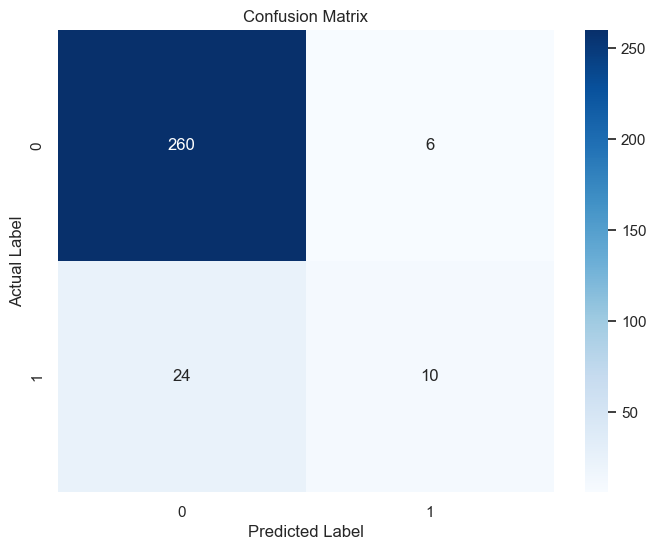

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['Absent', 'Present']))

              precision    recall  f1-score   support

      Absent       0.91      0.96      0.94        54
     Present       0.33      0.17      0.22         6

    accuracy                           0.88        60
   macro avg       0.62      0.56      0.58        60
weighted avg       0.85      0.88      0.87        60

